In [13]:
import numpy as np
import time
from matplotlib import pyplot as plt


def lasso(x, A, b, lambda_):
    return np.linalg.norm(A @ x - b, ord=2) ** 2 / 2 + lambda_ * np.linalg.norm(x, ord=1)


# 软阈值算子
def soft_thresholding_operator(x, lambda_):
    """
    实现软阈值算子
    :param x: 输入向量或标量
    :param lambda_: 阈值参数
    :return: 软阈值处理后的结果
    """
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)


# KKT停机准则
def check_kkt(x, A, b, lambda_):
    """验证Lasso问题的解是否满足KKT条件"""
    y = x + A.T @ (b - A @ x)
    return np.linalg.norm(soft_thresholding_operator(y, lambda_) - x, ord=2) / (1 + np.linalg.norm(x, ord=2))


def view_plot(y, res, iteration_times, log10=False):
    """绘制lasso值的迭代曲线，以及迭代时间曲线"""
    plt.figure(figsize=(10, 6))
    if log10:
        plt.semilogy(y)
    else:
        plt.plot(y)
    plt.ylabel('Lasso Value')
    plt.xlabel('Iteration Number')
    plt.show()

    # 绘制收敛曲线
    plt.figure(figsize=(10, 6))
    if log10:
        plt.semilogy(res)
    else:
        plt.plot(res)
    plt.ylabel('RES Value')
    plt.xlabel('Iteration Number')
    plt.show()

    # 绘制迭代时间曲线
    cumulative_times = []
    total_time = 0
    for time in iteration_times:
        total_time += time
        cumulative_times.append(total_time)

    num = len(iteration_times)
    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(10, 6))

    # 上方子图：累计运行时间
    ax1.plot(range(num), cumulative_times, label='Cumulative Run Time', color='blue')
    ax1.set_ylabel('Cumulative Time (s)')
    ax1.legend(loc='upper left')

    # 下方子图：单次迭代运行时间
    ax2.plot(range(num), iteration_times, label='Single Iteration Run Time', color='red')
    ax2.set_xlabel('Iteration Number')
    ax2.set_ylabel('Time per Iteration (s)')
    ax2.legend(loc='upper left')
    # 调整子图间的间距
    plt.tight_layout()

    # 显示图形
    plt.show()


def view_plot_2(y, res, iteration_times, axs, label, title):
    axs[0].set_title(title)
    axs[0].semilogy(y, label=label)
    axs[1].semilogy(res, label=label)
    # 绘制迭代时间曲线
    cumulative_times = []
    total_time = 0
    for time in iteration_times:
        total_time += time
        cumulative_times.append(total_time)
    axs[2].plot(cumulative_times, label=label)

# 近端梯度下降法求解Lasso回归问题

In [14]:
def pg_lasso(A, b, lambda_, x=None, max_iter=10000, tol=1e-5, plot=True, show_process=True):
    """
    使用近端梯度下降法求解Lasso回归问题
    :param A: 特征矩阵。
    :param b: 目标向量。
    :param lambda_: L1正则化参数。
    :param x: 权重向量初值。
    :param max_iter: 最大迭代次数，默认为10000。
    :param tol: 收敛容限，默认为1e-5。
    :param plot: 是否绘制收敛曲线，默认为True。
    :param show_process: 是否在迭代过程中显示信息，默认为True。
    :return:
        x: 求解得到的权重向量。
        res: 每次迭代的KKT条件满足程度。
        times: 每次迭代的时间。
    """
    # 初始化beta为零向量
    if x is None:
        x = np.zeros(A.shape[1])

    # 计算梯度的Lipschitz常数
    L = np.linalg.norm(A, ord=2) ** 2
    y = []
    res = []
    times = []
    # 迭代更新参数x
    time_0 = time.process_time()
    for i in range(max_iter):
        time_1 = time.process_time()

        # 计算梯度
        gradient = A.T @ (A @ x - b)
        # 近端梯度更新
        x = soft_thresholding_operator(x - gradient / L, lambda_ / L)
        time_2 = time.process_time()

        # 记录时间、Lasso值和KKT条件满足程度
        times.append(time_2 - time_1)  # 记录迭代时间
        y.append(lasso(x, A, b, lambda_))  # 计算lasso值

        # 检查收敛性
        res.append(check_kkt(x, A, b, lambda_))
        if res[-1] <= tol:
            print(f"收敛容限tol={tol}条件下, 利用PG算法求解的最终结果为(结果保留3位小数)\n{np.round(x, 3)}.")
            if plot:
                view_plot(y, res, times, log10=True)
            return x, y, res, times
        if show_process and ((i + 1) % 100 == 0 or (i + 1) == max_iter):
            print("%d:\tlasso value: %3e, \tres: %3e, \trun time: %3e" % (i + 1, y[-1], res[-1], time_2 - time_0))
    print("在最大迭代次数内, PG算法未达到收敛容限.")
    if plot:
        view_plot(y, res, times, log10=True)
    return x, y, res, times



# 加速近端梯度下降法求解Lasso回归问题

In [15]:
def apg_lasso(A, b, lambda_, x=None, max_iter=10000, tol=1e-5, plot=True, show_process=True):
    """
    使用加速梯度法（APG）求解Lasso回归问题。

    :param A: 特征矩阵。
    :param b: 目标向量。
    :param lambda_: L1正则化参数。
    :param x: 权重向量初值。
    :param max_iter: 最大迭代次数，默认为10000。
    :param tol: 收敛容限，默认为1e-5。
    :param plot: 是否绘制收敛曲线，默认为True。
    :param show_process: 是否在迭代过程中显示信息，默认为True。
    :return:
        x: 求解得到的权重向量。
        res: 每次迭代的KKT条件满足程度。
        times: 每次迭代的时间。
    """
    # 初始化变量
    m, n = A.shape
    # 初始化
    if x is None:
        x = np.zeros(n)
    x_old = x
    t = 1
    y = []
    times = []
    res = []

    # 计算梯度的Lipschitz常数
    L = np.linalg.norm(A, ord=2) ** 2

    # 开始计时
    time_0 = time.process_time()
    for i in range(max_iter):
        time_1 = time.process_time()

        # 更新动量
        beta = (i - 1) / (i + 2)
        v = x + beta * (x - x_old)

        # 计算梯度并进行软阈值操作
        gradient = A.T @ (A @ v - b)
        x_old = x
        x = soft_thresholding_operator(v - gradient / L, lambda_ / L)

        time_2 = time.process_time()

        # 记录时间、Lasso值和KKT条件满足程度
        times.append(time_2 - time_1)  # 记录迭代时间
        y.append(lasso(x, A, b, lambda_))  # 计算lasso值
        res.append(check_kkt(x, A, b, lambda_))

        # 检查收敛条件
        if res[-1] <= tol:
            print(f"收敛容限tol={tol}条件下, 利用APG算法求解的最终结果为(结果保留3位小数)\n{np.round(x, 3)}.")
            if plot:
                view_plot(y, res, times, log10=True)
            return x, y, res, times

        # 显示迭代过程信息
        if show_process and ((i + 1) % 100 == 0 or (i + 1) == max_iter):
            print("%d:\tlasso value: %3e, \tres: %3e, \trun time: %3e" % (i + 1, y[-1], res[-1], time_2 - time_0))

    # 如果未达到收敛条件，输出提示信息
    print("在最大迭代次数内, APG算法未达到收敛容限.")
    if plot:
        view_plot(y, res, times, log10=True)
    return x, y, res, times


# ADMM算法求解Lasso回归问题

In [16]:
def admm_lasso(A, b, lambda_, rho, x=None, max_iter=1000, tol=1e-5, plot=True, show_process=True):
    """
    使用ADMM算法求解Lasso回归问题
    
     
    :param A: 特征矩阵。
    :param b: 目标向量。
    :param lambda_: L1正则化参数。
    :param x: 权重向量初值。
    :param rho:
    :param max_iter: 最大迭代次数，默认为10000。
    :param tol: 收敛容限，默认为1e-5。
    :param plot: 是否绘制收敛曲线，默认为True。
    :param show_process: 是否在迭代过程中显示信息，默认为True。
    :return:
        x: 求解得到的权重向量。
        res: 每次迭代的KKT条件满足程度。
        times: 每次迭代的时间。
    """
    m, n = A.shape
    if x is None:
        x = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n)  # Lagrange multiplier
    res = []
    times = []
    y = []
    time_0 = time.process_time()
    for i in range(max_iter):
        time_1 = time.process_time()
        x = np.linalg.solve(A.T @ A + rho * np.eye(n), A.T @ b + rho * z - u)
        z = soft_thresholding_operator(x + u / rho, lambda_ / rho)
        u += x - z

        time_2 = time.process_time()
        times.append(time_2 - time_1)  # 记录迭代时间
        res.append(check_kkt(x, A, b, lambda_))
        y.append(lasso(x, A, b, lambda_))
        if res[-1] <= tol:
            print(f"收敛容限tol={tol}条件下, 利用ADMM算法求解的最终结果为(结果保留3位小数)\n{np.round(x, 3)}.")
            if plot:
                view_plot(y, res, times, log10=True)
            return x, y, res, times
        if show_process and ((i + 1) % 100 == 0 or (i + 1) == max_iter):
            print("%d:\tlasso value: %3e, \tres: %3e, \trun time: %3e" % (i + 1, y[-1], res[-1], time_2 - time_0))
    print("在最大迭代次数内, ADMM算法未达到收敛容限.")
    if plot:
        view_plot(y, res, times, log10=True)
    return x, y, res, times


# 数值模拟

In [17]:
# 数据生成
def generate_data(n_samples, n_features):
    matrixA = np.random.randn(n_samples, n_features)
    true_coef = np.random.uniform(0, 1, n_features)
    # 将系数向量中的大部分元素设置为零，以模拟稀疏性
    true_coef[abs(true_coef) < 0.6] = 0
    vectorb = np.dot(matrixA, true_coef) + np.random.normal(size=n_samples)
    return matrixA, vectorb, true_coef

100:	lasso value: 4.845600e+01, 	res: 5.641603e-01, 	run time: 1.562500e-02
200:	lasso value: 4.642314e+01, 	res: 5.228611e-01, 	run time: 3.125000e-02
300:	lasso value: 4.484221e+01, 	res: 4.895445e-01, 	run time: 3.125000e-02
400:	lasso value: 4.359344e+01, 	res: 4.538673e-01, 	run time: 4.687500e-02
500:	lasso value: 4.258444e+01, 	res: 4.290385e-01, 	run time: 4.687500e-02
600:	lasso value: 4.173862e+01, 	res: 4.023854e-01, 	run time: 6.250000e-02
700:	lasso value: 4.099821e+01, 	res: 3.814897e-01, 	run time: 7.812500e-02
800:	lasso value: 4.034618e+01, 	res: 3.619797e-01, 	run time: 7.812500e-02
900:	lasso value: 3.977022e+01, 	res: 3.423157e-01, 	run time: 7.812500e-02
1000:	lasso value: 3.927618e+01, 	res: 3.267499e-01, 	run time: 7.812500e-02
1100:	lasso value: 3.882282e+01, 	res: 3.120259e-01, 	run time: 1.093750e-01
1200:	lasso value: 3.840360e+01, 	res: 3.002608e-01, 	run time: 1.250000e-01
1300:	lasso value: 3.802897e+01, 	res: 2.852799e-01, 	run time: 1.562500e-01
1400:	la

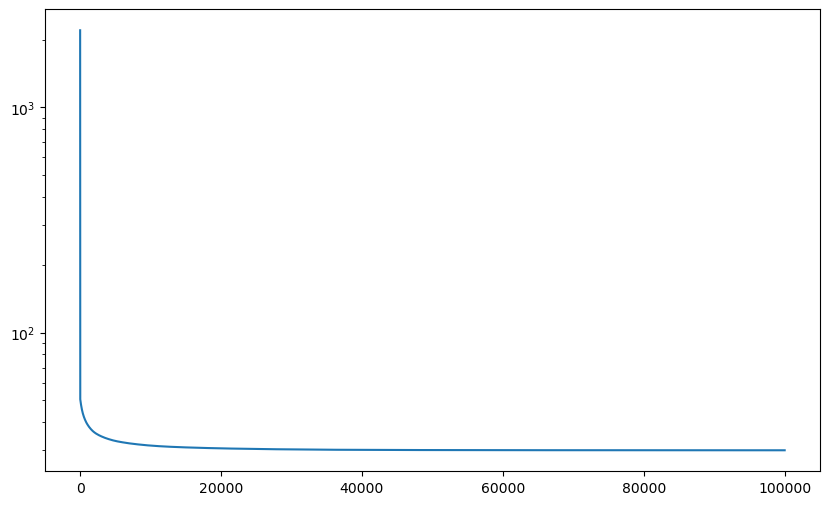

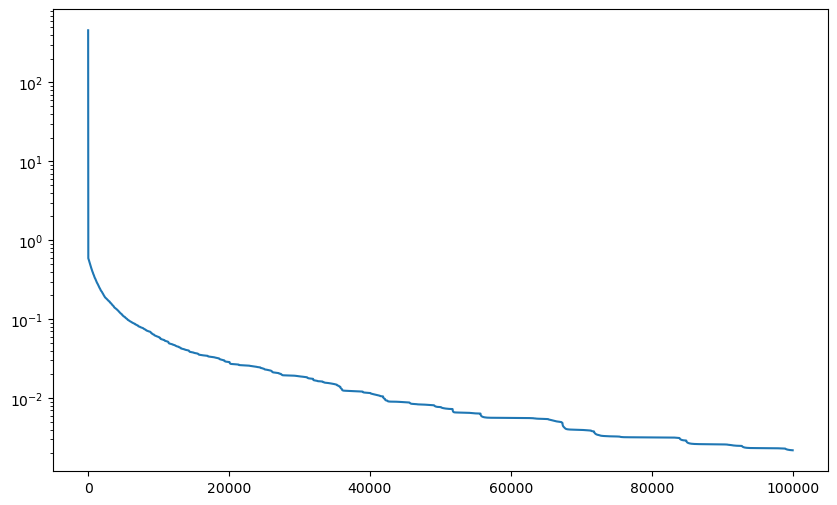

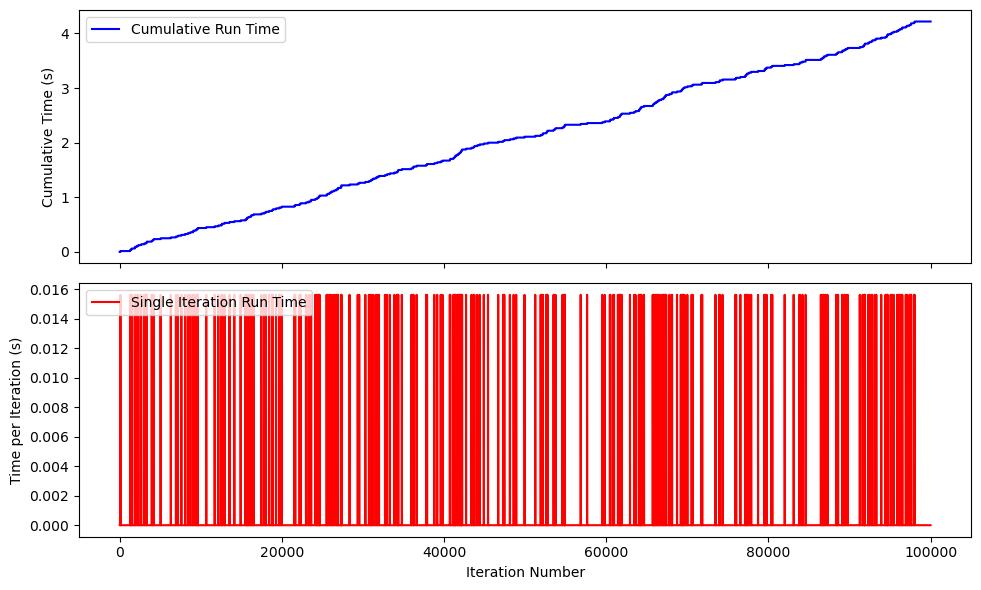

100:	lasso value: 3.821986e+01, 	res: 3.363878e-01, 	run time: 0.000000e+00
200:	lasso value: 3.321997e+01, 	res: 2.115318e-01, 	run time: 1.562500e-02
300:	lasso value: 3.141248e+01, 	res: 1.280507e-01, 	run time: 1.562500e-02
400:	lasso value: 3.066485e+01, 	res: 1.094661e-01, 	run time: 1.562500e-02
500:	lasso value: 3.030279e+01, 	res: 7.856967e-02, 	run time: 1.562500e-02
600:	lasso value: 3.012290e+01, 	res: 7.692899e-02, 	run time: 1.562500e-02
700:	lasso value: 3.006203e+01, 	res: 4.262825e-02, 	run time: 1.562500e-02
800:	lasso value: 3.003401e+01, 	res: 2.426093e-02, 	run time: 3.125000e-02
900:	lasso value: 3.002659e+01, 	res: 2.678126e-02, 	run time: 3.125000e-02
1000:	lasso value: 3.002407e+01, 	res: 8.833917e-03, 	run time: 4.687500e-02
1100:	lasso value: 3.002227e+01, 	res: 7.596553e-03, 	run time: 4.687500e-02
1200:	lasso value: 3.002107e+01, 	res: 7.562737e-03, 	run time: 4.687500e-02
1300:	lasso value: 3.001963e+01, 	res: 6.330594e-03, 	run time: 6.250000e-02
1400:	la

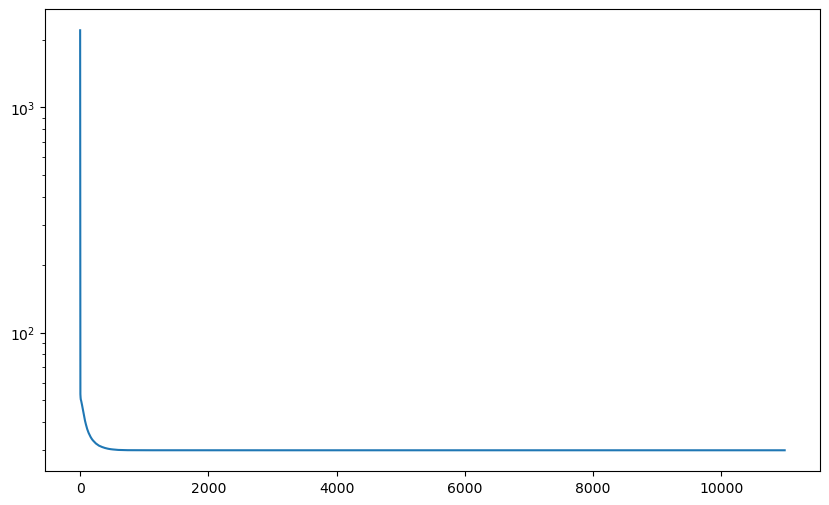

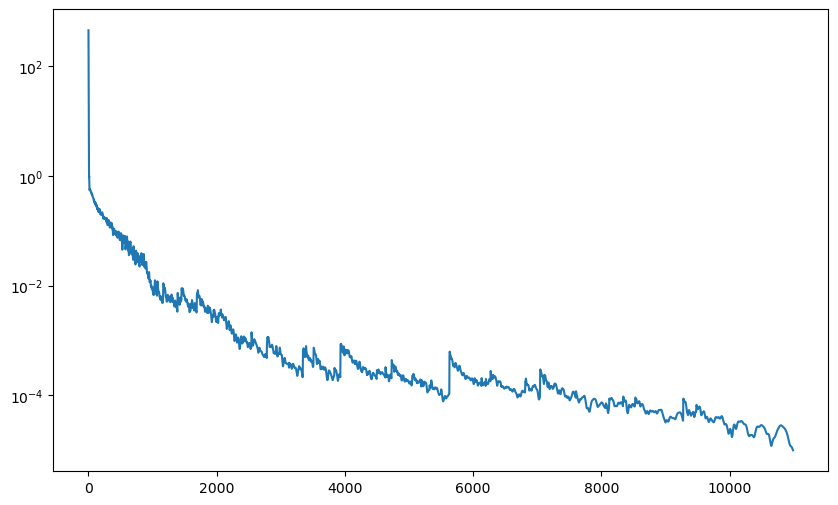

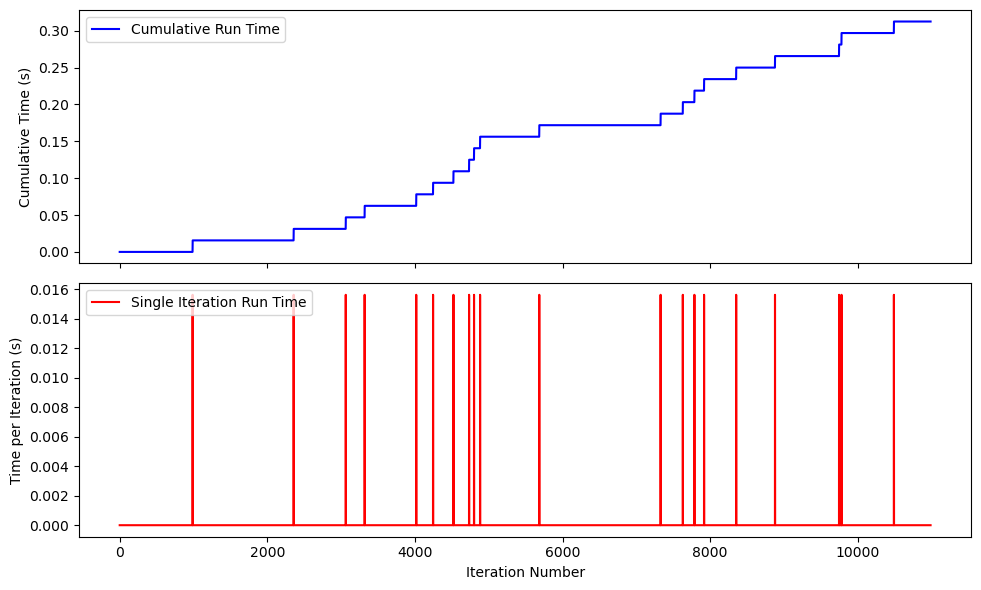

100:	lasso value: 3.030416e+01, 	res: 3.822187e-03, 	run time: 1.937500e+00
200:	lasso value: 3.012928e+01, 	res: 1.494631e-03, 	run time: 2.765625e+00
300:	lasso value: 3.007418e+01, 	res: 8.341120e-04, 	run time: 3.859375e+00
400:	lasso value: 3.005262e+01, 	res: 5.039613e-04, 	run time: 4.671875e+00
500:	lasso value: 3.003630e+01, 	res: 3.050177e-04, 	run time: 5.546875e+00
600:	lasso value: 3.003252e+01, 	res: 1.985908e-04, 	run time: 6.625000e+00
700:	lasso value: 3.002981e+01, 	res: 1.469446e-04, 	run time: 7.468750e+00
800:	lasso value: 3.002273e+01, 	res: 1.133284e-04, 	run time: 8.328125e+00
900:	lasso value: 3.002077e+01, 	res: 9.056958e-05, 	run time: 9.078125e+00
1000:	lasso value: 3.002294e+01, 	res: 7.616733e-05, 	run time: 1.007812e+01
1100:	lasso value: 3.002190e+01, 	res: 6.411667e-05, 	run time: 1.076562e+01
1200:	lasso value: 3.001951e+01, 	res: 5.445925e-05, 	run time: 1.175000e+01
1300:	lasso value: 3.001956e+01, 	res: 4.716591e-05, 	run time: 1.262500e+01
1400:	la

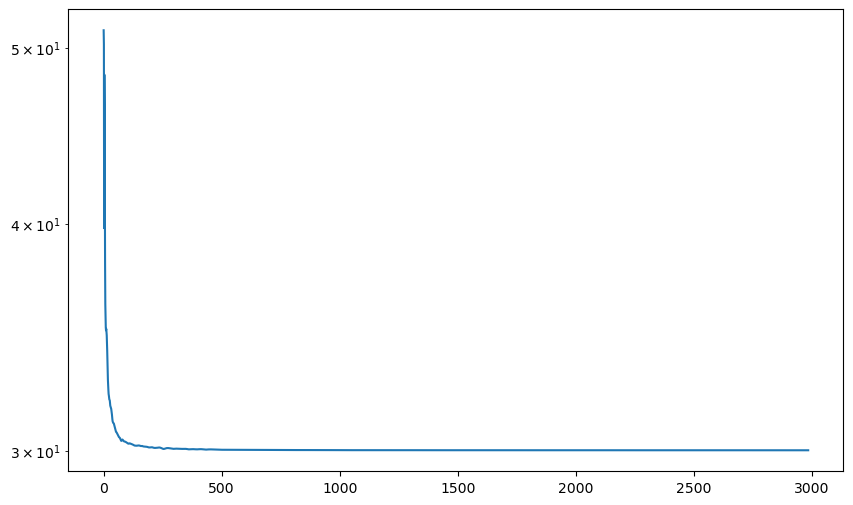

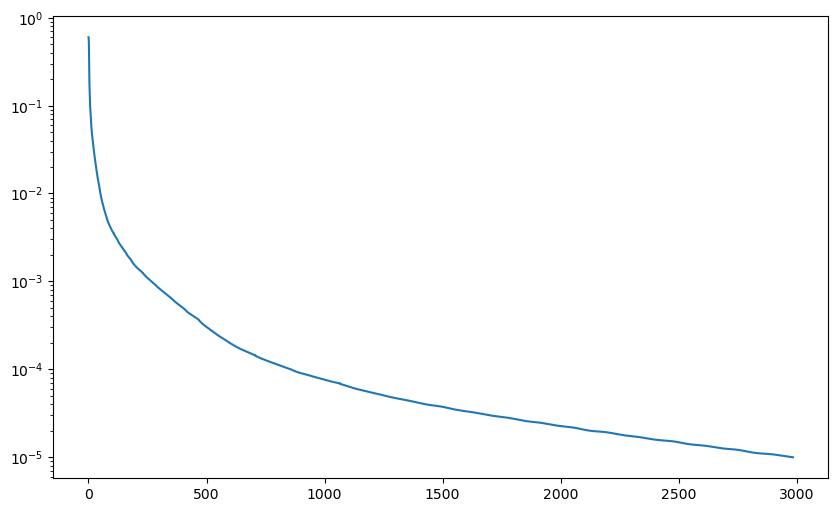

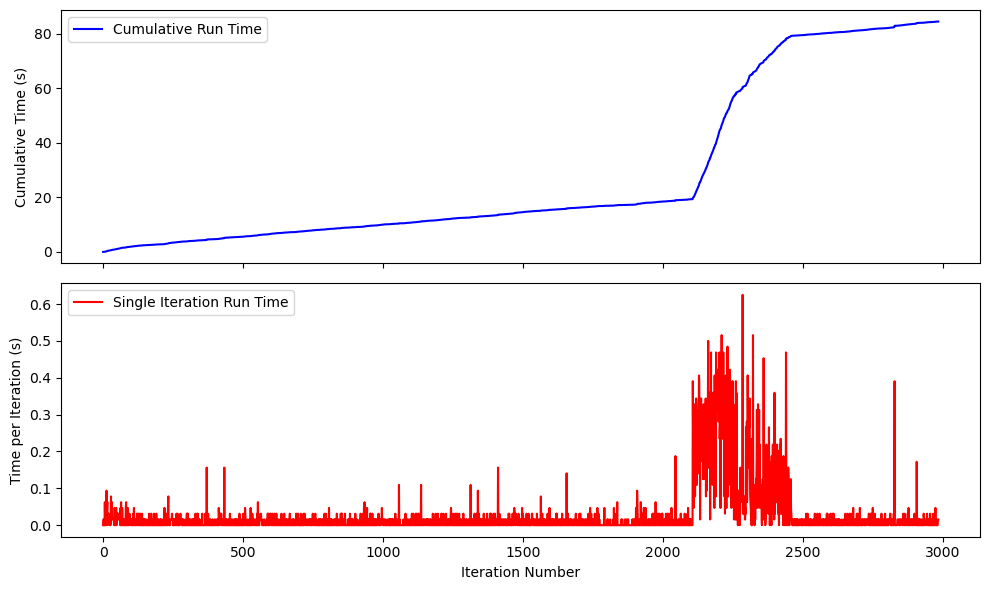

In [18]:
# 设置参数
iters = int(1e5)
tol = 1e-5

np.random.seed(0)
matrixA, vectorb, true_coef = generate_data(100, 1000)

x_pg, y_pg, res_pg, times_pg = pg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=True, show_process=True)
x_apg, y_apg, res_apg, times_apg = apg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=True,
                                             show_process=True)
x_admm, y_admm, res_admm, times_admm = admm_lasso(matrixA, vectorb, 0.4, 1, max_iter=iters, tol=tol, plot=True,
                                                  show_process=True)

# 对比结果绘制


在最大迭代次数内, PG算法未达到收敛容限.
收敛容限tol=1e-05条件下, 利用APG算法求解的最终结果为(结果保留3位小数)
[ 0.    -0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    -0.    -0.     0.    -0.    -0.     0.    -0.     0.835 -0.
 -0.     0.075  0.    -0.     0.    -0.     0.    -0.     0.     0.
  0.     0.     1.129  0.     1.43   0.    -0.    -0.     2.147  0.
 -0.    -0.497 -0.     0.    -0.     1.207 -0.159  0.     0.    -0.
  0.     0.165 -0.     0.     0.     0.     0.     0.     0.     0.
 -0.294 -0.067  0.    -0.     0.     0.    -0.     0.     0.    -0.116
 -0.     0.     0.     0.    -0.508 -0.    -0.    -0.     0.137 -0.
  0.     1.079  2.676  0.    -0.     0.     0.15   0.    -0.     0.
  0.     0.373 -0.     0.     0.    -0.    -0.    -0.    -0.     0.
  0.     0.     0.     0.488  0.845  0.    -0.     0.    -0.     0.
 -0.    -0.752 -0.413 -0.    -0.     0.279  0.     0.     0.     0.
 -0.    -0.878  0.     0.     0.    -0.    -0.    -0.932  0.    -0.
 -0.     0.    -0.    -0.    -0.     0.    -0.

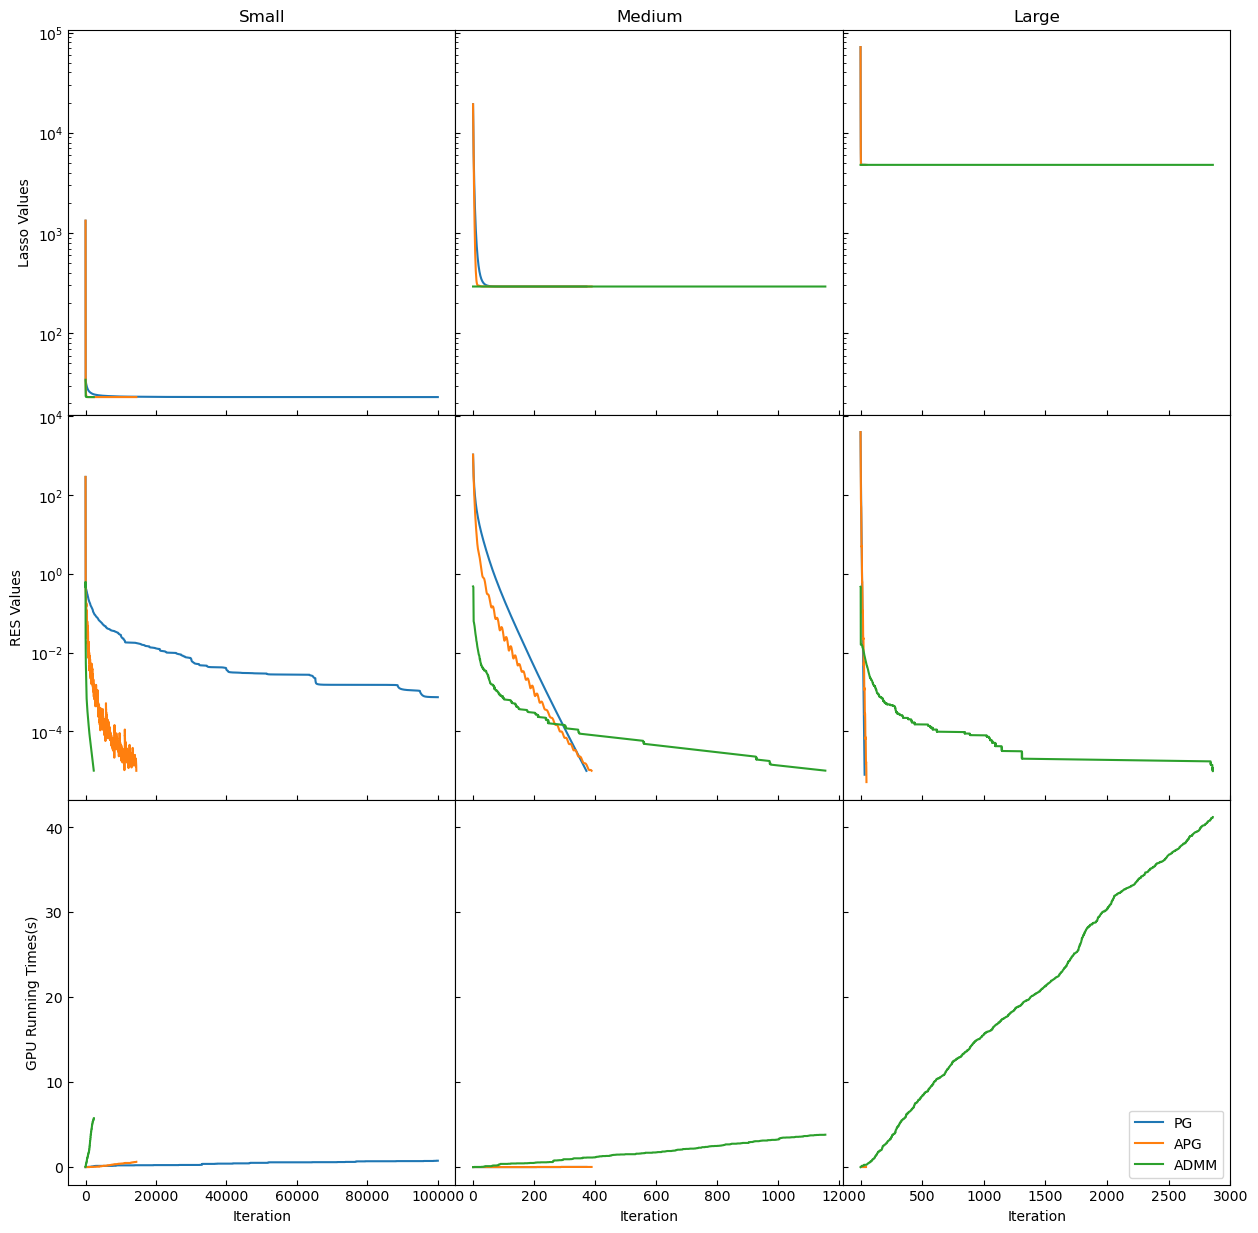

In [25]:
iters = int(1e5)
tol = 1e-5

# 设置画布
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey='row', sharex='col')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.subplots_adjust(wspace=0, hspace=0)
algorithms = ['PG', 'APG', 'ADMM']
data_scales = ['Small', 'Medium', 'Large']
np.random.seed(0)

for j, num in enumerate([100, 1000, 10000]):
    matrixA, vectorb, true_coef = generate_data(num, 500)
    # show_process=False 不输出中间过程
    x_pg, y_pg, res_pg, times_pg = pg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=False,
                                            show_process=False)
    x_apg, y_apg, res_apg, times_apg = apg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=False,
                                                 show_process=False)
    x_admm, y_admm, res_admm, times_admm = admm_lasso(matrixA, vectorb, 0.4, 1, max_iter=iters, tol=tol, plot=False,
                                                      show_process=False)
    Y = [y_pg, y_apg, y_admm]
    RES = [res_pg, res_apg, res_admm]
    TIMES = [times_pg, times_apg, times_admm]
    for i in range(3):
        view_plot_2(Y[i], RES[i], TIMES[i], axs[:, j], algorithms[i], data_scales[j])
axs[2, 0].set_xlabel('Iteration')
axs[2, 1].set_xlabel('Iteration')
axs[2, 2].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Lasso Values')
axs[1, 0].set_ylabel('RES Values')
axs[2, 0].set_ylabel('GPU Running Times(s)')

plt.legend(loc='lower right')
plt.show()

## 数据维度 1000

在最大迭代次数内, PG算法未达到收敛容限.
收敛容限tol=1e-05条件下, 利用APG算法求解的最终结果为(结果保留3位小数)
[-0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00
  0.000e+00  0.000e+00  9.800e-02 -0.000e+00 -0.000e+00  0.000e+00
 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00
 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00
 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00  1.760e-01  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  2.950e-01  0.000e+00
 -0.000e+00 -0.000e+00  2.970e-01 -0.000e+00  0.000e+00  0.000e+00
  0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
 -0.000e+00  0.000e+00  0.000e+00 -0.000e+00  3.500e-01  0.000e+00
  0.000e+00 -4.060e-01  0.000e+00  0.000e+00  0.000e+00  0.000e+00
 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  4.900e-01 -0.000e+00
  4.900e-01  0.000e+00  1.469e+00 -0.000e+00 -0.000e+00  4.740

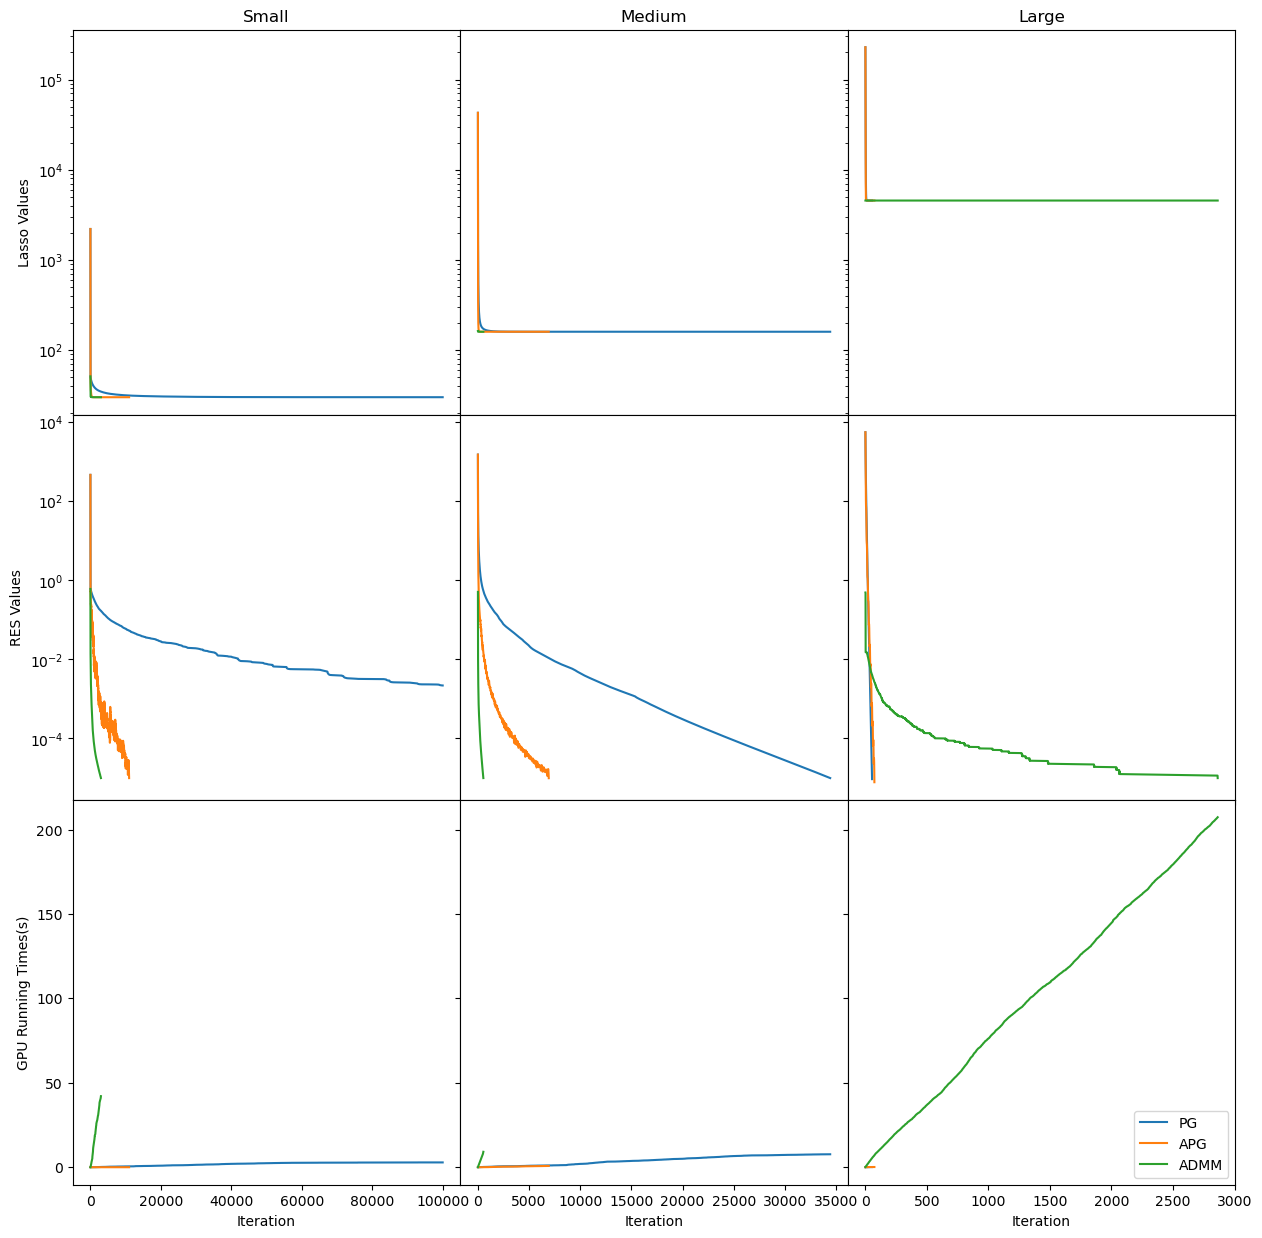

In [19]:
iters = int(1e5)
tol = 1e-5

# 设置画布
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey='row', sharex='col')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.subplots_adjust(wspace=0, hspace=0)
algorithms = ['PG', 'APG', 'ADMM']
data_scales = ['Small', 'Medium', 'Large']
np.random.seed(0)

for j, num in enumerate([100, 1000, 10000]):
    matrixA, vectorb, true_coef = generate_data(num, 1000)
    # show_process=False 不输出中间过程
    x_pg, y_pg, res_pg, times_pg = pg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=False,
                                            show_process=False)
    x_apg, y_apg, res_apg, times_apg = apg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=False,
                                                 show_process=False)
    x_admm, y_admm, res_admm, times_admm = admm_lasso(matrixA, vectorb, 0.4, 1, max_iter=iters, tol=tol, plot=False,
                                                      show_process=False)
    Y = [y_pg, y_apg, y_admm]
    RES = [res_pg, res_apg, res_admm]
    TIMES = [times_pg, times_apg, times_admm]
    for i in range(3):
        view_plot_2(Y[i], RES[i], TIMES[i], axs[:, j], algorithms[i], data_scales[j])
axs[2, 0].set_xlabel('Iteration')
axs[2, 1].set_xlabel('Iteration')
axs[2, 2].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Lasso Values')
axs[1, 0].set_ylabel('RES Values')
axs[2, 0].set_ylabel('GPU Running Times(s)')

plt.legend(loc='lower right')
plt.show()

## 数据维度 10000

在最大迭代次数内, PG算法未达到收敛容限.
收敛容限tol=0.001条件下, 利用APG算法求解的最终结果为(结果保留3位小数)
[ 0. -0.  0. ...  0. -0. -0.].
在最大迭代次数内, PG算法未达到收敛容限.
收敛容限tol=0.001条件下, 利用APG算法求解的最终结果为(结果保留3位小数)
[ 1.514 -0.    -0.    ... -0.106  1.596 -0.   ].
收敛容限tol=0.001条件下, 利用PG算法求解的最终结果为(结果保留3位小数)
[ 0.009  0.742 -0.017 ...  0.982  0.812  0.017].
收敛容限tol=0.001条件下, 利用APG算法求解的最终结果为(结果保留3位小数)
[ 0.009  0.742 -0.017 ...  0.982  0.812  0.017].


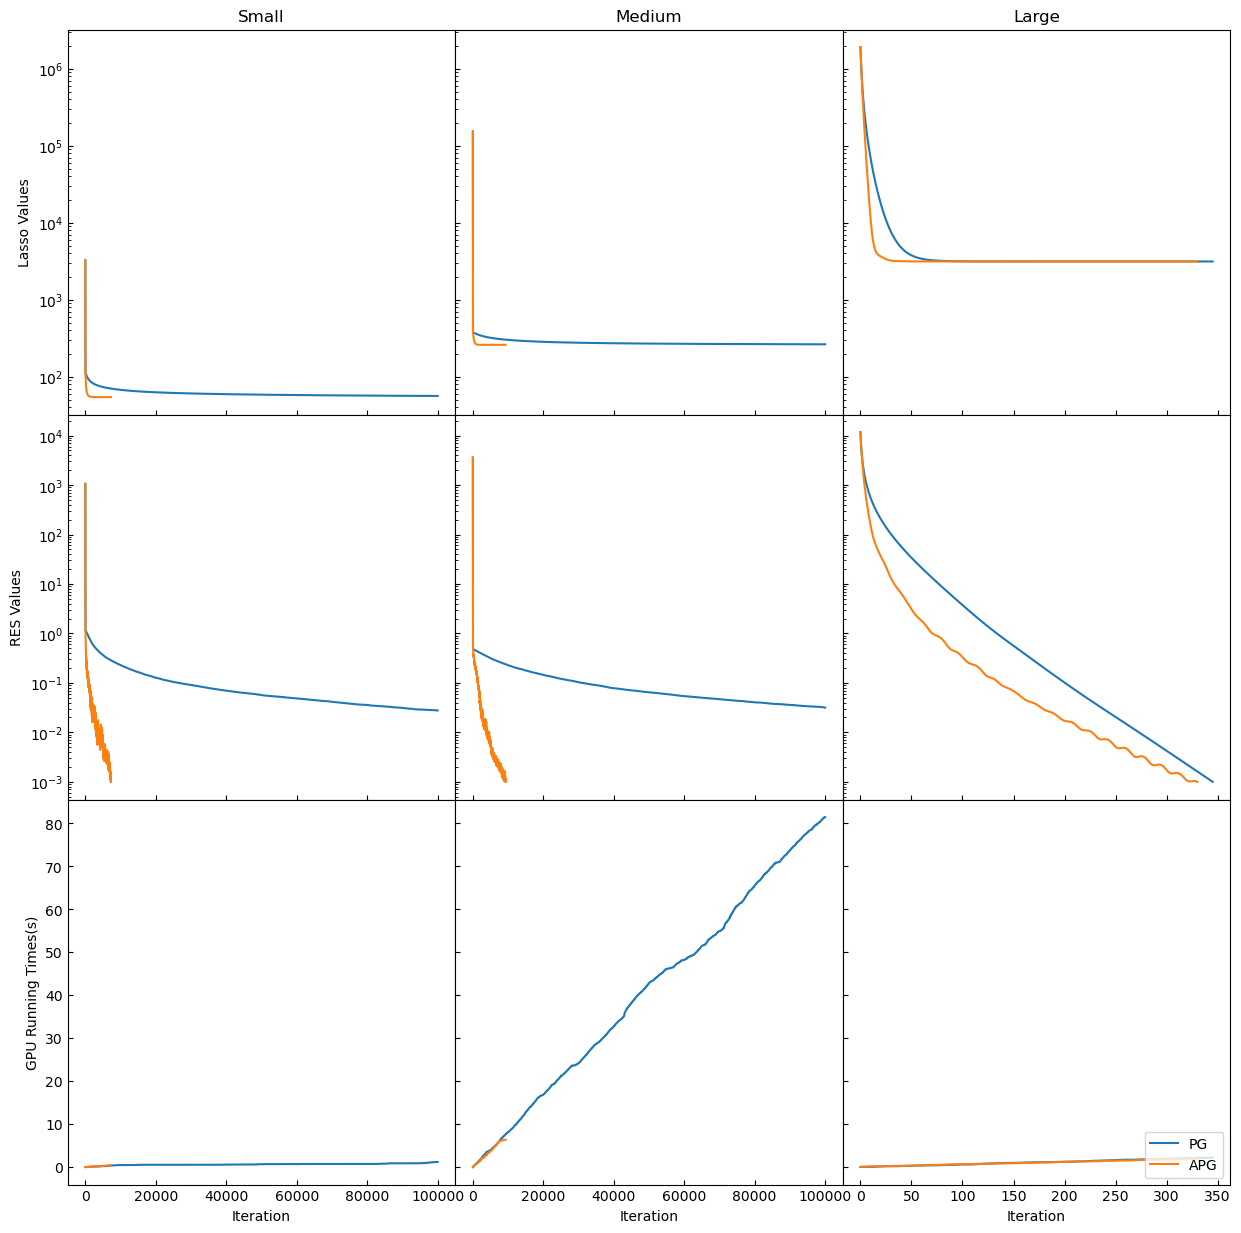

In [23]:
iters = int(1e5)
tol = 1e-3
# 设置画布
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey='row', sharex='col')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.subplots_adjust(wspace=0, hspace=0)
algorithms = ['PG', 'APG', 'ADMM']
data_scales = ['Small', 'Medium', 'Large']
np.random.seed(1)

for j, num in enumerate([100, 1000, 10000]):
    matrixA, vectorb, true_coef = generate_data(num, 5000)
    # show_process=False 不输出中间过程
    x_pg, y_pg, res_pg, times_pg = pg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=False,
                                            show_process=False)
    x_apg, y_apg, res_apg, times_apg = apg_lasso(matrixA, vectorb, 0.4, max_iter=iters, tol=tol, plot=False,
                                                 show_process=False)
    # x_admm, y_admm, res_admm, times_admm = admm_lasso(matrixA, vectorb, 0.4, 1, max_iter=iters, tol=tol, plot=False,
    #                                                   show_process=False)
    Y = [y_pg, y_apg]
    RES = [res_pg, res_apg]
    TIMES = [times_pg, times_apg]
    for i in range(2):
        view_plot_2(Y[i], RES[i], TIMES[i], axs[:, j], algorithms[i], data_scales[j])
axs[2, 0].set_xlabel('Iteration')
axs[2, 1].set_xlabel('Iteration')
axs[2, 2].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Lasso Values')
axs[1, 0].set_ylabel('RES Values')
axs[2, 0].set_ylabel('GPU Running Times(s)')

plt.legend(loc='upper right')
plt.show()

In [ ]:
x_admm, y_admm, res_admm, times_admm = admm_lasso(matrixA, vectorb, 0.4, 1, max_iter=iters, tol=tol, plot=False,show_process=True)